<a href="https://colab.research.google.com/github/Iaquine/Analise-de-sentimento-da-base-Olist/blob/master/Analise_de_sentimento_da_base_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas necessárias

In [1]:
!pip install scikeras

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [3]:
!pip install ray[tune] tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 9.6 MB/s eta 0:00:00


In [4]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scikeras.wrappers import KerasClassifier
from keras_tuner.tuners import Hyperband
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import GridSearchCV

In [5]:
# Suprimir warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Download dos recursos do NLTK

In [6]:
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

# Carregamento dos dados

In [7]:
df = pd.read_csv('olist_order_reviews_dataset.csv')

# Pré-processamento dos dados


In [8]:
# Pré-processamento dos dados
def preprocess_text(text, stemming=False, remove_stopwords=False):
    """
    Pré-processa o texto removendo caracteres especiais, convertendo para minúsculas,
    e opcionalmente aplicando stemming e remoção de stop words.

    Args:
      text: O texto a ser pré-processado.
      stemming: Flag para indicar se o stemming deve ser aplicado.
      remove_stopwords: Flag para indicar se as stop words devem ser removidas.

    Returns:
      O texto pré-processado.
    """
    text = text.lower()  # Converter para minúsculas
    text = ''.join([char for char in text if char.isalnum() or char == ' '])  # Remover caracteres especiais

    if remove_stopwords:
        stop_words = set(stopwords.words('portuguese'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)

    if stemming:
        stemmer = RSLPStemmer()
        words = text.split()
        words = [stemmer.stem(word) for word in words]
        text = ' '.join(words)

    return text


# Aplica o pré-processamento ao texto das avaliações


In [9]:
df['processed_review'] = df['review_comment_message'].apply(lambda x: preprocess_text(str(x), stemming=True, remove_stopwords=True))


# Análise exploratória dos dados


## 1. Distribuição das classes

In [10]:
print("Distribuição das classes:")
print(df['review_score'].value_counts(normalize=True))

Distribuição das classes:
review_score
5    0.577763
4    0.192917
1    0.115133
3    0.082430
2    0.031756
Name: proportion, dtype: float64


In [11]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,processed_review
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,nan
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,nan
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,nan
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,receb bem ant praz estipul
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,parabém loj lannist ador compr internet segur ...
...,...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,nan
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,nan
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,excel mochil entreg sup rápid sup recom loj
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,nan


## 2. Nuvem de palavras para cada classe


________________


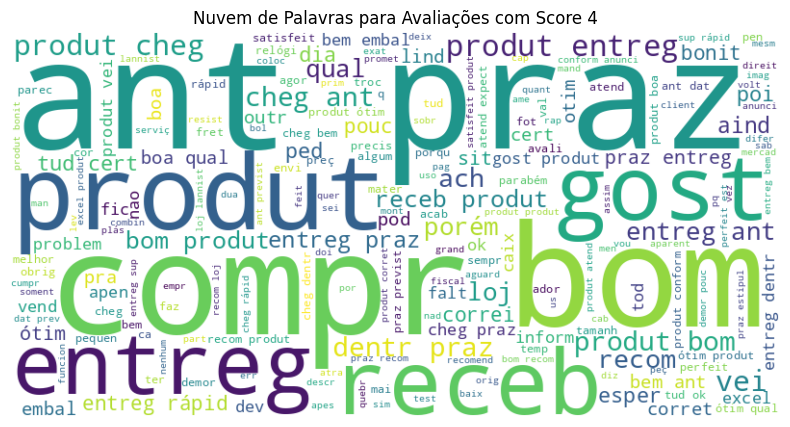

________________


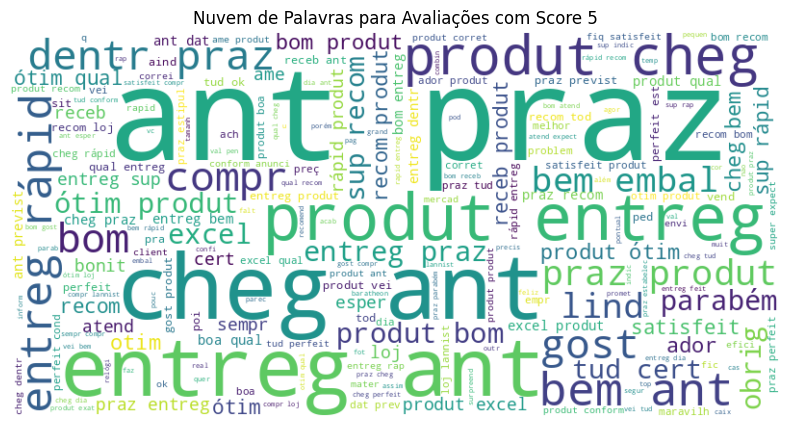

________________


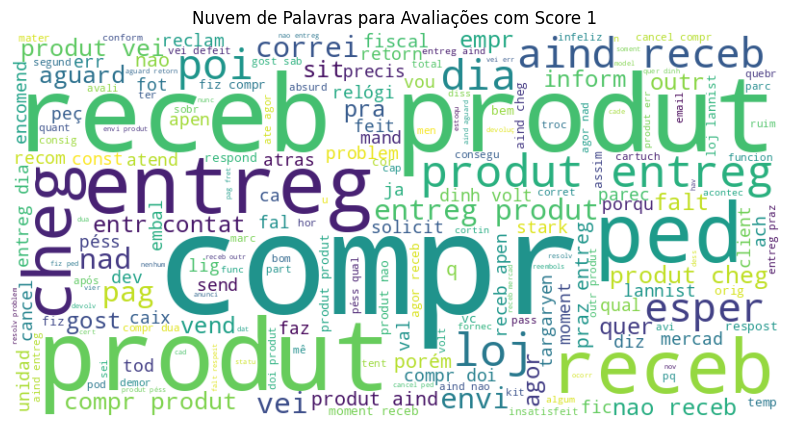

________________


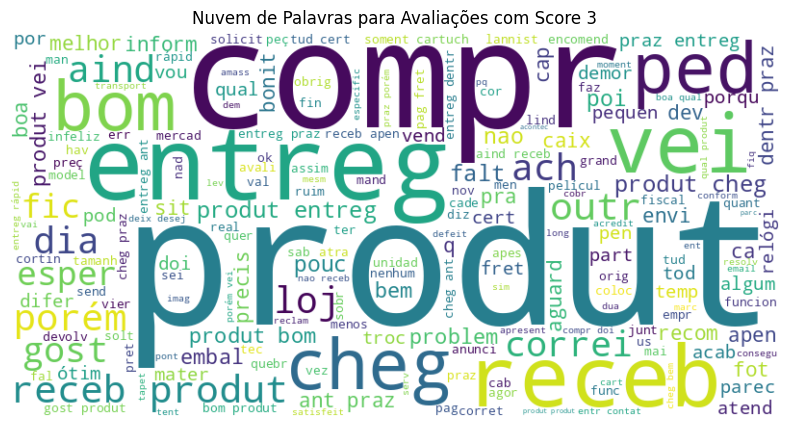

________________


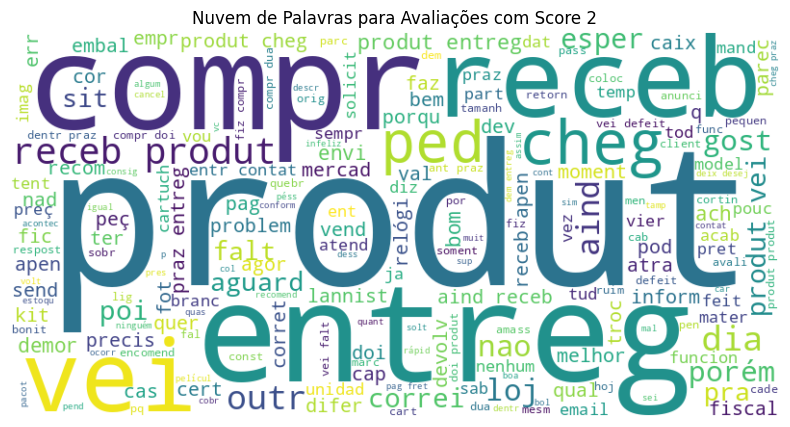

In [12]:
# Filtrar linhas com NaN nas colunas relevantes
filtered_df = df.dropna(subset=['review_score', 'processed_review'])

for score in filtered_df['review_score'].unique():
    # Selecionar apenas as avaliações com o score atual e ignorar 'NaN' em 'processed_review'
    valid_reviews = filtered_df[filtered_df['review_score'] == score]['processed_review']

    # Remover valores 'NaN' explicitamente
    valid_reviews = valid_reviews[valid_reviews.notna()]

    # Concatenar os textos em uma string e remover 'nan' (caso esteja como string)
    text = ' '.join(valid_reviews.astype(str).tolist())
    text = text.replace('nan', '')  # Remove todas as ocorrências de 'nan'

    print("________________")

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras para Avaliações com Score {score}')
    plt.show()


# Divisão dos dados em conjuntos de treinamento e teste


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_review'], df['review_score'], test_size=0.2, random_state=42
)

In [14]:
# Converte y_train para one-hot encoding
y_train = to_categorical(y_train, num_classes=6)

# Converte y_test para one-hot encoding
y_test = to_categorical(y_test, num_classes=6)

# Tokenização dos textos


In [15]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding das sequências

In [16]:
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Função para criar o modelo RNN

In [17]:
def create_rnn_model(model_type='lstm', num_layers=1, units=32, dropout_rate=0.2):
    """
    Cria um modelo RNN com base no tipo especificado.
    """
    model = Sequential()
    model.add(Embedding(5000, 128, input_length=max_length))
    model.add(Reshape((max_length, 128)))

    if model_type == 'lstm':
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(LSTM(units))  # Última camada LSTM sem return_sequences=True
    elif model_type == 'gru':
        for _ in range(num_layers - 1):
            model.add(GRU(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(GRU(units))  # Última camada GRU sem return_sequences=True
    elif model_type == 'stacked_lstm':
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(LSTM(units))  # Última camada LSTM sem return_sequences=True

    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Treinamento e avaliação dos modelos


In [18]:
model_types = ['lstm', 'gru', 'stacked_lstm']
results = []

In [19]:
for model_type in model_types:
    print(f'Treinando modelo {model_type}...')

    # Cria o modelo com parâmetros fixos
    model = create_rnn_model(model_type=model_type, num_layers=2, units=64, dropout_rate=0.2)

    model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

    # Avaliação do modelo
    y_pred_probs = model.predict(X_test_padded)  # Armazena as probabilidades aqui
    y_pred = np.argmax(y_pred_probs, axis=-1)  # Obtém as classes previstas

    # Converte y_test de volta para o formato de classes
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred)  # Usa as classes previstas
    precision = precision_score(y_test_classes, y_pred, average='weighted')
    recall = recall_score(y_test_classes, y_pred, average='weighted')
    f1 = f1_score(y_test_classes, y_pred, average='weighted')

    results.append({
        'model_type': model_type,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })


Treinando modelo lstm...
Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5757 - loss: 1.2163 - val_accuracy: 0.5821 - val_loss: 1.1973
Epoch 2/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5791 - loss: 1.1963 - val_accuracy: 0.5821 - val_loss: 1.1958
Epoch 3/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5793 - loss: 1.1964 - val_accuracy: 0.5821 - val_loss: 1.1937
Epoch 4/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5779 - loss: 1.1982 - val_accuracy: 0.5821 - val_loss: 1.1934
Epoch 5/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5786 - loss: 1.1971 - val_accuracy: 0.5821 - val_loss: 1.1940
Epoch 6/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5776 - loss: 1.2001 - val_accuracy: 0.5821 - val_loss: 1.1962
Epoch 7/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5806 - loss: 1.1931 - val_accuracy: 0.5821 - val_loss: 1.1967
Epoch 8/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy:

# Criação dos gráficos de comparação


In [20]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']


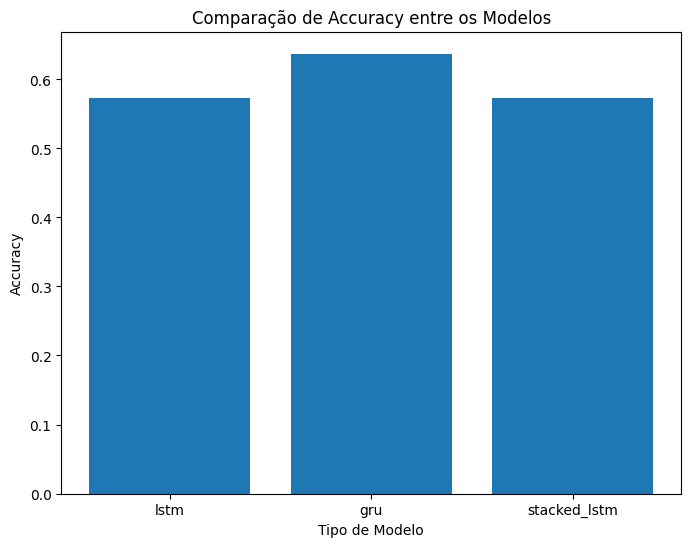

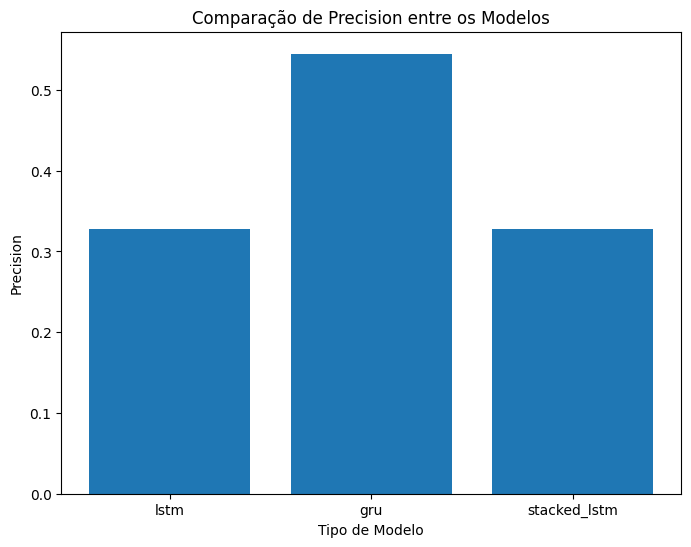

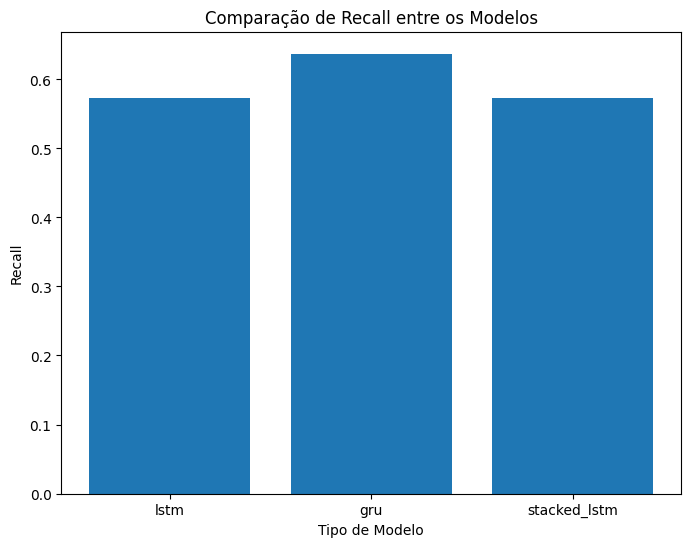

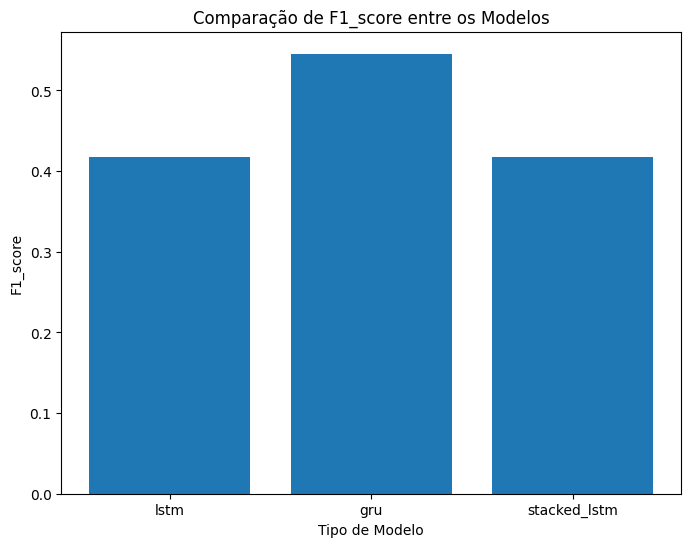

In [21]:
for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.bar(
        [result['model_type'] for result in results],
        [result[metric] for result in results]
    )
    plt.title(f'Comparação de {metric.capitalize()} entre os Modelos')
    plt.xlabel('Tipo de Modelo')
    plt.ylabel(metric.capitalize())
    plt.show()

#Usando o modelo selecionado: RNN-GRU

In [22]:
# Cria o modelo GRU
model = Sequential()
model.add(Embedding(5000, 256, input_length=max_length))
model.add(Reshape((max_length, 256)))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(128))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Treina o modelo
model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5723 - loss: 1.2416 - val_accuracy: 0.5821 - val_loss: 1.1991
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5779 - loss: 1.2043 - val_accuracy: 0.5821 - val_loss: 1.1969
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5777 - loss: 1.2035 - val_accuracy: 0.5821 - val_loss: 1.1934
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5755 - loss: 1.2050 - val_accuracy: 0.5821 - val_loss: 1.1939
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5748 - loss: 1.2066 - val_accuracy: 0.5821 - val_loss: 1.1940
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5802 - loss: 1.1954 - val_accuracy: 0.5821 - val_loss: 1.1944
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5779 - loss: 1.2006 - val_accuracy: 0.5821 - val_loss: 1.1961
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5782 - loss: 1.1994 - 

In [24]:
# Função para classificar uma frase
def classify_sentence(sentence):
    """Classifica o sentimento de uma frase."""
    sentence = preprocess_text(sentence)
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)

    score = np.argmax(prediction)
    return score

- 0: Sentimento muito negativo

- 1: Sentimento negativo

- 2: Sentimento levemente negativo

- 3: Sentimento neutro

- 4: Sentimento levemente positivo

- 5: Sentimento positivo

In [25]:
frase = "Este produto é incrível! Recomendo a todos."
score = classify_sentence(frase)
print(f"Frase: {frase}")
print(f"Classificação: {score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Frase: Este produto é incrível! Recomendo a todos.
Classificação: 5


In [26]:
frase = "Odiei"
score = classify_sentence(frase)
print(f"Frase: {frase}")
print(f"Classificação: {score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Frase: Odiei
Classificação: 5


A classificação ainda não está ideal. O modelo está classificando frases com sentimentos negativos como "Odiei" como positivas, o que indica que ele precisa de mais ajustes para capturar a nuances da linguagem e do contexto.

Vamos tentar outra abordagem.

In [27]:
# Download dos recursos do NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [28]:
# Carregamento dos dados
df = pd.read_csv('olist_order_reviews_dataset.csv')

In [29]:
# Pré-processamento dos dados com Lematização
def preprocess_text(text, lemmatization=True, remove_stopwords=True):
    """
    Pré-processa o texto removendo caracteres especiais, convertendo para minúsculas,
    aplicando lematização e remoção de stop words.
    """
    # Converte a entrada para string e lida com valores nulos
    text = str(text)
    if text.lower() == 'nan':
        text = ''

    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char == ' '])

    if remove_stopwords:
        stop_words = set(stopwords.words('portuguese'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)

    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        text = ' '.join(words)

    return text

In [30]:
# Aplica o pré-processamento com Lematização
df['processed_review'] = df['review_comment_message'].apply(preprocess_text)

In [31]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_review'], df['review_score'], test_size=0.2, random_state=42
)

In [32]:
# Tokenização
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [33]:
# Padding
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [34]:
# Cria o modelo GRU com parâmetros ajustados
model = Sequential()
model.add(Embedding(5000, 256, input_length=max_length))
model.add(Reshape((max_length, 256)))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(128))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Treina o modelo
model.fit(X_train_padded, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5740 - loss: 1.2351 - val_accuracy: 0.5821 - val_loss: 1.1975
Epoch 2/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5892 - loss: 1.1687 - val_accuracy: 0.6548 - val_loss: 0.9881
Epoch 3/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6510 - loss: 0.9895 - val_accuracy: 0.6576 - val_loss: 0.9799
Epoch 4/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6512 - loss: 0.9697 - val_accuracy: 0.6568 - val_loss: 0.9723
Epoch 5/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6619 - loss: 0.9403 - val_accuracy: 0.6512 - val_loss: 0.9806
Epoch 6/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6728 - loss: 0.9198 - val_accuracy: 0.6542 - val_loss: 0.9922
Epoch 7/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6817 - loss: 0.8971 - val_accuracy: 0.6529 - val_loss: 1.0105
Epoch 8/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6845 - loss: 0.8838 - 

In [36]:
# Função para classificar uma frase (com lematização)
def classify_sentence(sentence):
    """Classifica o sentimento de uma frase."""
    sentence = preprocess_text(sentence)
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)

    score = np.argmax(prediction)
    return score

In [37]:
frases = ["Este produto é incrível! Recomendo a todos.", "Odiei o produto", "Quebrou na primeira semana", "Ok"]
for frase in frases:
    score = classify_sentence(frase)
    print(f"Frase: {frase}")
    print(f"Classificação: {score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Frase: Este produto é incrível! Recomendo a todos.
Classificação: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Frase: Odiei o produto
Classificação: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Frase: Quebrou na primeira semana
Classificação: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Frase: Ok
Classificação: 5


In [38]:
model.save('modelo_sentimento.h5')